# DataLoader

In [29]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader

# arguments of a DataLoader
'''
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=<function default_collate>,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)
'''

'\nDataLoader(dataset, batch_size=1, shuffle=False, sampler=None,\n           batch_sampler=None, num_workers=0, collate_fn=<function default_collate>,\n           pin_memory=False, drop_last=False, timeout=0,\n           worker_init_fn=None, *, prefetch_factor=2,\n           persistent_workers=False)\n'

## Important arguments in dataloader

1. shuffle - 是否打亂dataset，當sampler有輸入時，shuffle的值就沒意義

  ```
  False : SequentialSampler(test_data)
  True : RandomSampler(test_data)
  ```
2. batch_size - 每一個batch的大小 (dafault = 1)
3. num_workers - 設定讀取數據的線程數目 (dafault = 0)
4. drop_las - 是否拋棄batch_size剩下的data (dafault = False)
 

In [2]:
from torch.utils.data import Sampler, SequentialSampler, RandomSampler
test_data = [1,5,78,9,68]

#SequentialSampler
print("------SequentialSampler--------")
seq_index = SequentialSampler(test_data)
for x in seq_index:
    print(x)
    
#RandomSampler
print("------RandomSampler--------")
random_index = RandomSampler(test_data)
for x in random_index:
    print(x)

------SequentialSampler--------
0
1
2
3
4
------RandomSampler--------
2
4
3
0
1


# DataLoader，Sampler，Dataset，Collate_fn 交互關係

1. DataLoader 可以視為 dataset 的容器
2. 透過 Sampler 選取 index （可以隨機亂選，也可以照順序選)
3. 利用 indices 取出 dataset 中相對應的 data，將所有取出的 data 打包成 list
4. Collate_fn 將 list 中所有的資料組合成一個 batch 的 data
5. 最後，DataLoader 將整理好的 batch data 傳回
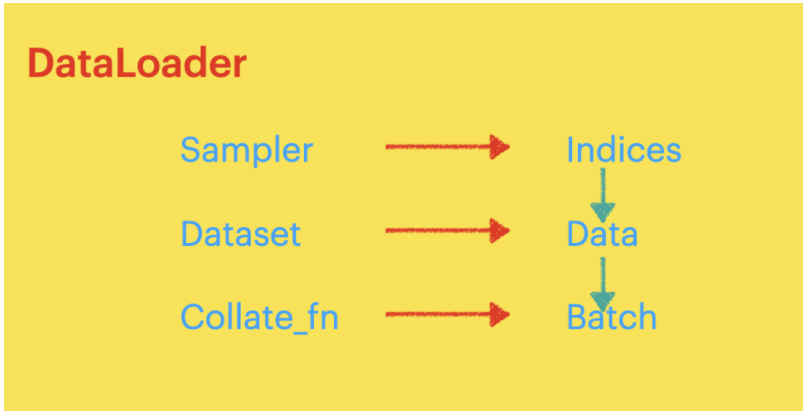


# 讀取長度、大小不一致的資料 （Ex.評論）

利用客製化的 sampler 與 collate_fn，使 batch 資料的方式變成將長度接近的再加上 padding 後，做成 batch 資料回傳

In [6]:
import re
# 前處理，將文字做tokenize轉為id

def preprocess(corpus):
    
    word_dic = set()
    processed_corpus = []
    
    for sentence in corpus:
        #將所有字詞轉為小寫
        sentence = sentence.lower()
        #只保留英文
        sentence = re.sub('[^a-zA-Z]',' ',sentence)
        
        sentence = sentence.split()
        
        #添加字詞到字典中
        word_dic |= set(sentence)
        processed_corpus.append(sentence)
    
    #建立字詞ID清單
    word2idx = dict()
    for word in word_dic:
        if word not in word2idx:
            idx = len(word2idx) + 1
            word2idx[word] = idx
    
    #將文本轉為ID型式
    id_mapping = lambda x: word2idx[x]
    processed_corpus = [list(map(id_mapping, sentence)) for sentence in processed_corpus]
    
    return processed_corpus, word2idx

In [10]:
corpus = ['i love nlp', 'hi, nice to meet you', 'deep learning is fun', 'enjoy cupoy nlp course']
labels = [0,0,0,0]
corpus, word2idx = preprocess(corpus)
corpus = sorted(corpus, key=lambda x: len(x), reverse=True) #將文本由長到短排列
corpus, word2idx

([[6, 5, 12, 3, 15], [9, 7, 14, 2], [10, 4, 8, 13], [11, 1, 8]],
 {'course': 13,
  'cupoy': 4,
  'deep': 9,
  'enjoy': 10,
  'fun': 2,
  'hi': 6,
  'i': 11,
  'is': 14,
  'learning': 7,
  'love': 1,
  'meet': 3,
  'nice': 5,
  'nlp': 8,
  'to': 12,
  'you': 15})

In [22]:
# 定義客製化collate_fn，將長度不一的文本pad 0 變成相同長度
def collate_fn(batch):

    corpus, labels = zip(*batch) 
    
    ### create pads for corpus ###
    lengths = [len(x) for x in corpus]
    max_length = max(lengths)
    
    batch_corpus = []
    
    for i in range(len(corpus)):
        # pad corpus
        tmp_pads = torch.zeros(max_length)
        tmp_pads[:lengths[i]] = corpus[i]
        tmp_pads.view(-1, 1)
        batch_corpus.append(tmp_pads.view(1,-1))

    return torch.cat(batch_corpus,dim=0), torch.tensor(labels) , torch.tensor(lengths)

In [23]:
# 定義隨機連續的客製化sampler
class RandomSequentialSampler(Sampler):
    
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        
    def __iter__(self):
        n_batch = len(self) // self.batch_size #calculate number of batches
        leftover = len(self) % self.batch_size #calculate the remaining part
        index = np.zeros(len(self), dtype=int)
        
        #batch
        for i in range(n_batch):
            start_idx = random.randint(0, len(self) - self.batch_size)
            batch_idx = start_idx + np.arange(0, self.batch_size)
            index[i*self.batch_size:(i+1)*self.batch_size] = batch_idx #同一個batch的資料擁有同樣的index值
            # array([7, 8, 9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 0, 0])
            
        #dealing with leftover
        if leftover:
            tail_start = random.randint(0, len(self) - leftover)
            tail_index = tail_start + np.arange(0, leftover)
            index[-leftover:] = tail_index
            
        return iter(index)
    
    def __len__(self):
        
        return len(self.data_source)

In [27]:

class dataset(Dataset):
    '''custom dataset to load reviews and labels
    Parameters
    ----------
    data_pairs: list
        directory of all review-label pairs
    vocab: list
        list of vocabularies
    '''
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

In [33]:
custom_dst = dataset(corpus, labels)
custom_sampler = RandomSequentialSampler(corpus, 4)
data_loader = DataLoader(custom_dst, sampler=custom_sampler, collate_fn=collate_fn, batch_size=4)
next(iter(data_loader))

'''
return: corpus(調整成一致長度tensor), labels, 文本的原始長度

(tensor([[ 6.,  5., 12.,  3., 15.],
         [ 9.,  7., 14.,  2.,  0.],
         [10.,  4.,  8., 13.,  0.],
         [11.,  1.,  8.,  0.,  0.]]),
 tensor([0, 0, 0, 0]),
 tensor([5, 4, 4, 3]))